In [1]:
# Base Data Science snippet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
# from tqdm import tqdm_notebook

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
import tensorflow_probability as tfp
import tensorflow as tf
tfd = tfp.distributions

##### References: 
- https://medium.com/tensorflow/regression-with-probabilistic-layers-in-tensorflow-probability-e46ff5d37baf
- https://brendanhasz.github.io/2018/12/03/tfp-regression


##### Hierarchical bayesian models
- https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/HLM_TFP_R_Stan.ipynb

# Create a dataset

## Dataset 1: from the tutorial

In [6]:
w0 = 0.125
b0 = 5.
x_range = [-20, 60]

def load_dataset(n=150, n_tst=150):
    np.random.seed(43)
    def s(x):
        g = (x - x_range[0]) / (x_range[1] - x_range[0])
        return 3 * (0.25 + g**2.)
    x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
    eps = np.random.randn(n) * s(x)
    y = (w0 * x * (1. + np.sin(x)) + b0) + eps
    x = x[..., np.newaxis]
    x_tst = np.linspace(*x_range, num=n_tst).astype(np.float32)
    x_tst = x_tst[..., np.newaxis]
    return y, x, x_tst

y, x, x_tst = load_dataset()

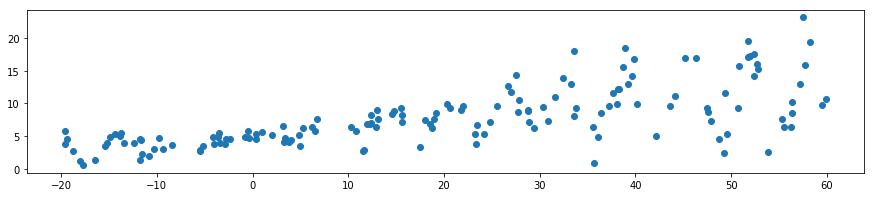

In [7]:
plt.figure(figsize = (15,3))
plt.scatter(x,y)
plt.show()

## Dataset 2: simple linear expression

In [8]:
x = np.linspace(0,10,100)
xm = x[...,np.newaxis]
# y = 1+30*np.random.rand(100)*x
y = 1+3*x+20*np.random.rand(100)

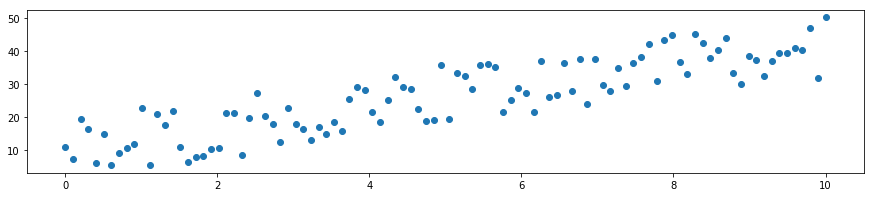

In [9]:
plt.figure(figsize = (15,3))
plt.scatter(x,y)
plt.show()

# Simple linear regression with Tensorflow

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1)
])

model.compile(optimizer = "adam",loss = "mse")

In [11]:
model.fit(xm,y,epochs = 4000,verbose = False)

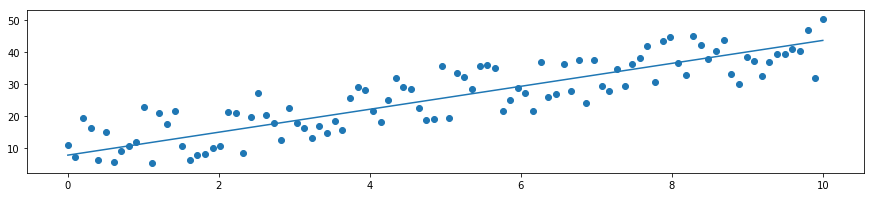

In [12]:
plt.figure(figsize = (15,3))
plt.plot(x,model.predict(x))
plt.scatter(x,y)
plt.show()

In [13]:
model.get_weights()

[array([[3.5761533]], dtype=float32), array([7.8127465], dtype=float32)]

# Regression with Prior

Hello everyone ! 
I am both a beginner in bayesian stats and probabilistic programming, 

I am trying to do **simple linear regression with a toy dataset with a predefined prior on the bias**. 
So far I have found several ways of doing bayesian linear regressions with TFP (correct me if I'm wrong) including: using a shallow neural network with one Dense flipout layer, GLMs, STS models, Edward2 models.

Let's say my dataset is linear relationship 3x + 1 + noise, what would be the best method to fit a linear regression saying explicity my prior was distributed on a Normal distribution centered in 10 (to force the bias posterior to be a compromise between 1 and 10). 

So far I found that maybe the DenseFlipout option was the best with a simple architecture as such:
```python
model = tf.keras.Sequential([
    tfp.layers.DenseFlipout(
        1,
        activation = "linear",
        bias_prior_fn = tfp.layers.default_mean_field_normal_fn()
    )
])

model.compile(optimizer = "adam",loss = "mse")
```

But do I define a custom prior on the bias ? The documentation around the default_mean_field_normal_fn() is obscure. 

Also my goal is to be the more generalizable as possible, with custom distributions for the priors, or priors on the coefficients as well.

Thanks a lot !
Theo

In [43]:
model2 = tf.keras.Sequential([
    tfp.layers.DenseFlipout(
        1,
        activation = "linear",
        bias_prior_fn = tfp.layers.default_mean_field_normal_fn()
    )
])

model2.compile(optimizer = "adam",loss = "mse")

In [46]:
tfp.layers.default_multivariate_normal_fn(
    "float32",
    (10,2),
    "yo",
    True,
    None
)

AttributeError: 'str' object has no attribute 'as_numpy_dtype'

In [44]:
model2.fit(xm,y,epochs = 2000,verbose = False)

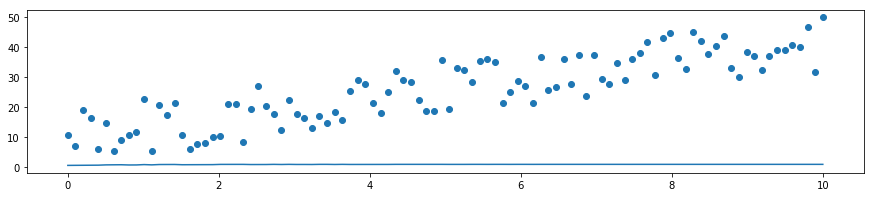

In [45]:
plt.figure(figsize = (15,3))
plt.plot(x,model2.predict(x))
plt.scatter(x,y)
plt.show()

# GLM with tfp
https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Generalized_Linear_Models.ipynb

In [37]:
coefs,lr,is_conv,num_iter = tfp.glm.fit(model_matrix=xm,response=y,
            model = tfp.glm.Normal()
           )

In [38]:
def predict(x,a,b=0.0):
    return a*x+b

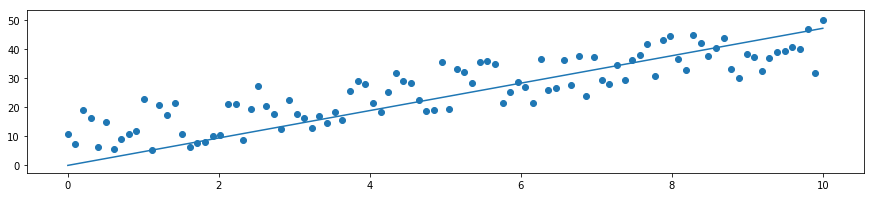

In [39]:
plt.figure(figsize = (15,3))
plt.plot(x,predict(x,coefs.numpy()[0]))
plt.scatter(x,y)
plt.show()

# Custom implementation
https://github.com/tensorflow/probability/issues/339

# With Edward
https://brendanhasz.github.io/2018/12/03/tfp-regression

In [49]:
ed = tfp.edward2

In [53]:
shape = x.shape
shape

(100,)

In [58]:
coefs = ed.Normal(loc = tf.zeros([D,1]),scale = tf.ones([D,1]),name = "coefs")


In [62]:
tf.matmul(tf.Variable(xm),coefs)

InvalidArgumentError: cannot compute MatMul as input #1(zero-based) was expected to be a double tensor but is a float tensor [Op:MatMul] name: MatMul/

In [56]:
D = 1
coefs = ed.Normal(loc = tf.zeros([D,1]),scale = tf.ones([D,1]),name = "coefs")
bias = ed.Normal(loc = tf.zeros([1]),scale = tf.ones([1]),name = "bias")
predictions = ed.Normal(
    loc = tf.matmul(xm,coefs)+bias,
    name = "predictions"
)

InvalidArgumentError: cannot compute MatMul as input #1(zero-based) was expected to be a double tensor but is a float tensor [Op:MatMul] name: MatMul/

In [ ]:
def linear_regression(features):
  D = features.shape[1]      #number of dimensions
  coeffs = ed.Normal(        #normal prior on weights
      loc=tf.zeros([D,1]),
      scale=tf.ones([D,1]),
      name="coeffs")
  bias = ed.Normal(          #normal prior on bias
      loc=tf.zeros([1]), 
      scale=tf.ones([1]),
      name="bias") 
  noise_std = ed.HalfNormal( #half-normal prior on noise std
      scale=tf.ones([1]),
      name="noise_std")
  predictions = ed.Normal(   #normally-distributed noise
      loc=tf.matmul(features, coeffs)+bias,
      scale=noise_std,
      name="predictions")
  return predictions